# Лабораторная работа №1
### Дьячков Вадим, 33501/4

### Цели работы
1. Научиться реализвывать многослойный перцептрон (MLP)

### Инициализация окружения

In [1]:
%matplotlib inline
import numpy as np
import itertools
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.io import savemat

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from descartes import PolygonPatch

np.random.seed(42)
sns.set(font_scale=1.25)

BLUE = '#0074D9'
RED = '#FF4136'

## №1. Крестики-нолики

Разделим таблицу $4\times 4$ на крестики и нолики так, чтобы классы "O" (0) и "X" (1) были линейно неразделимы:

\begin{cases}
y = f(X)\\
X = [x_1, x_2]\\
x_i \in \{1, 2, 3, 4\}\\
y_i \in \{0, 1\}
\end{cases}

In [2]:
grid = np.array([[0 if np.random.random() > 0.5 else 1 for i in range(4)] for j in range(4)])
grid

array([[1, 0, 0, 0],
       [1, 1, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 1, 1]])

In [3]:
def fun(x):
    x = np.array(x)
    if len(x.shape) == 1:
        return grid[x[0] - 1, x[1] - 1]
    else:
        return np.array([fun(xi) for xi in x])[np.newaxis].T

In [4]:
fun(np.array([1, 2])), fun([4, 4])

(0, 1)

In [5]:
P = np.array(list(itertools.product([1, 2, 3, 4], repeat=2)))
T = fun(P)

print('x1 x2    y')
for i in range(len(P)):
    print(P[i], '->', T[i][0])

x1 x2    y
[1 1] -> 1
[1 2] -> 0
[1 3] -> 0
[1 4] -> 0
[2 1] -> 1
[2 2] -> 1
[2 3] -> 1
[2 4] -> 0
[3 1] -> 0
[3 2] -> 0
[3 3] -> 1
[3 4] -> 0
[4 1] -> 0
[4 2] -> 1
[4 3] -> 1
[4 4] -> 1


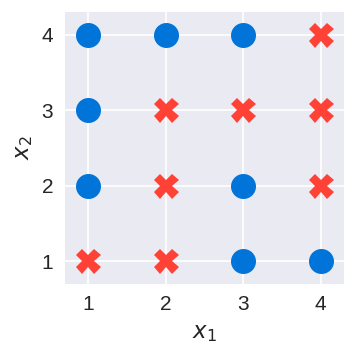

In [6]:
def draw_tic_tac_toe(X, Y, markersize=15):
    fig = plt.figure(figsize=(3, 3), dpi=120)
    for i in range(len(X)):
        x1, x2 = X[i]
        y = Y[i][0]
        m = 'X' if y == 1 else 'o'
        c = RED if y == 1 else BLUE
        plt.plot(x1, x2, m, markersize=markersize, color=c)
    plt.xticks([1, 2, 3, 4])
    plt.yticks([1, 2, 3, 4])
    plt.xlim([0.7, 4.3])
    plt.ylim([0.7, 4.3])
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    return fig
    
fig = draw_tic_tac_toe(P, T)
plt.savefig('../pics/1_1.png', bbox_inches='tight')
plt.show()

## Планирование MLP

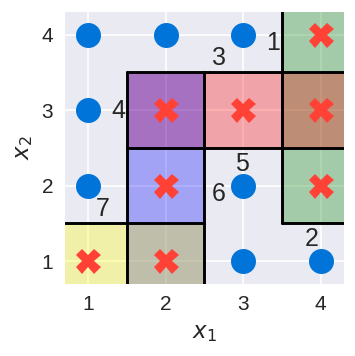

In [7]:
fig = draw_tic_tac_toe(P, T)
    
plt.plot([3.5, 3.5], [1.5, 5], c='k')
plt.text(3.3, 3.8, '1')

plt.plot([3.5, 5], [1.5, 1.5], c='k')
plt.text(3.8, 1.2, '2')

plt.plot([1.5, 5], [3.5, 3.5], c='k')
plt.text(2.6, 3.6, '3')

plt.plot([1.5, 1.5], [0, 3.5], c='k')
plt.text(1.3, 2.9, '4')

plt.plot([1.5, 5], [2.5, 2.5], c='k')
plt.text(2.9, 2.2, '5')

plt.plot([2.5, 2.5], [0, 3.5], c='k')
plt.text(2.6, 1.8, '6')

plt.plot([0, 2.5], [1.5, 1.5], c='k')
plt.text(1.1, 1.6, '7')

plt.fill_between([3.5, 5], 5, 1.5, facecolor='green', alpha=0.3)
plt.fill_between([1.5, 5], 3.5, 2.5, facecolor='red', alpha=0.3)
plt.fill_between([1.5, 2.5], 3.5, 0, facecolor='blue', alpha=0.3)
plt.fill_between([0, 2.5], 1.5, 0, facecolor='yellow', alpha=0.3)
plt.savefig('../pics/1_2_1.png', bbox_inches='tight')
plt.show()

<img src='scheme.png'>

4 выпуклые области, ограниченные прямыми:

$$
\begin{cases}
>1\\
>2
\end{cases}
\hspace{1cm}
\begin{cases}
<3\\
>4\\
>5
\end{cases}
\hspace{1cm}
\begin{cases}
<3\\
>4\\
<6
\end{cases}
\hspace{1cm}
\begin{cases}
<6\\
<7
\end{cases}
$$

### Первый слой:

1: $x_1 - 3.5 = 0 \rightarrow y_{11}$

2: $x_2 - 1.5 = 0 \rightarrow y_{12}$

3: $-x_2 + 3.5 = 0 \rightarrow y_{13}$

4: $x_1 - 1.5 = 0 \rightarrow y_{14}$

5: $x_2 - 2.5 = 0 \rightarrow y_{15}$

6: $-x_1 + 2.5 = 0 \rightarrow y_{16}$

7: $-x_2 + 1.5 = 0 \rightarrow y_{17}$

In [8]:
W01 = np.array([[1, 0, -3.5],
                [0, 1, -1.5],
                [0, -1, 3.5],
                [1, 0, -1.5],
                [0, 1, -2.5],
                [-1, 0, 2.5],
                [0, -1, 1.5]])

### Второй слой:

1: $y_{11} + y_{12} - 1.5 = 0 \rightarrow y_{21}$

2: $y_{13} + y_{14} + y_{15} - 2.5 = 0 \rightarrow y_{22}$

3: $y_{13} + y_{14} + y_{16} - 2.5 = 0 \rightarrow y_{23}$

4: $y_{16} + y_{17} - 1.5 = 0 \rightarrow y_{24}$

In [9]:
W12 = np.array([[1, 1, 0, 0, 0, 0, 0, -1.5],
                [0, 0, 1, 1, 1, 0, 0, -2.5],
                [0, 0, 1, 1, 0, 1, 0, -2.5],
                [0, 0, 0, 0, 0, 1, 1, -1.5]])

### Третий слой:

1: $y = y_{21} + y_{22} + y_{23} + y_{24} - 0.5$

In [10]:
W23 = np.array([1, 1, 1, 1, -0.5])

## Реализация

### На коленке

In [11]:
def predict(X):
    X = np.array(X)
    if len(X.shape) == 1:
        X01 = X[np.newaxis].T
        X01 = np.append(X01, [[1]], axis=0)  # add bias

        A1 = W01.dot(X01)  # activations of first layer
        X12 = np.where(A1 > 0, 1, 0)
        X12 = np.append(X12, [[1]], axis=0)

        A2 = W12.dot(X12)
        X23 = np.where(A2 > 0, 1, 0)
        X23 = np.append(X23, [[1]], axis=0)

        return 1 if W23.dot(X23) > 0 else 0
    else:
        return np.array([predict(Xi) for Xi in X])[np.newaxis].T

In [12]:
Y = predict(P)
np.equal(T, Y)

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]], dtype=bool)

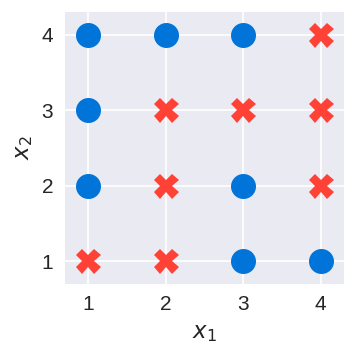

In [13]:
draw_tic_tac_toe(P, Y)
plt.show()

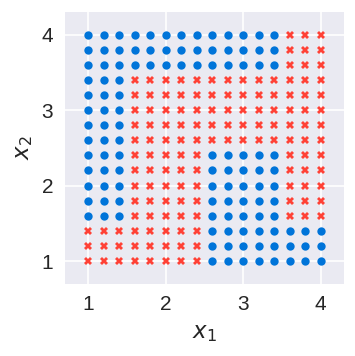

In [14]:
t = np.linspace(1, 4, 16)
P_big = np.array(list(itertools.product(t, t)))
Y_big = predict(P_big)
draw_tic_tac_toe(P_big, Y_big, 5)
plt.show()

savemat('matlab/1_big.mat', mdict={'P_big': P_big, 'T_big': Y_big})

Можно заметить, что все 16 точек (и не только они) классифицированы верно.

### На keras

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.utils import plot_model
from keras.backend import sigmoid

def binary_activation(x):
    return sigmoid(100000 * x)

def set_weights(model, W01, W12, W23):
    W = [
        W01.T[0:-1],  # weights of 1st layer
        W01.T[-1],  # bias of 1st layer
        W12.T[0:-1],
        W12.T[-1],
        W23[np.newaxis].T[0:-1],
        W23[np.newaxis].T[-1]
    ]
    model.set_weights(W)

model = Sequential()

model.add(Dense(7, input_shape=(2,), activation=binary_activation, name='Lines'))
model.add(Dense(4, activation=binary_activation, name='Convex_figures'))
model.add(Dense(1, activation=binary_activation, name='Any_figure'))

model.compile(loss='mean_squared_error',
              optimizer='SGD',
              metrics=['binary_accuracy'])

set_weights(model, W01, W12, W23)

Using TensorFlow backend.


In [16]:
Y = model.predict(P)
np.equal(T, Y)

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]], dtype=bool)

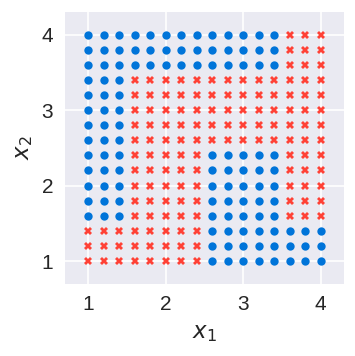

In [17]:
draw_tic_tac_toe(P_big, Y_big, 5)
plt.show()

Можно заметить, что все 16 точек (и не только они) классифицированы верно.

## №2. Логическая функция 5 переменных

In [18]:
grid = {'{0:05b}'.format(i): 1 if i in [5, 10, 13, 15, 16, 21, 24, 26] else 0 
        for i in range(32)}

In [19]:
grid

{'00000': 0,
 '00001': 0,
 '00010': 0,
 '00011': 0,
 '00100': 0,
 '00101': 1,
 '00110': 0,
 '00111': 0,
 '01000': 0,
 '01001': 0,
 '01010': 1,
 '01011': 0,
 '01100': 0,
 '01101': 1,
 '01110': 0,
 '01111': 1,
 '10000': 1,
 '10001': 0,
 '10010': 0,
 '10011': 0,
 '10100': 0,
 '10101': 1,
 '10110': 0,
 '10111': 0,
 '11000': 1,
 '11001': 0,
 '11010': 1,
 '11011': 0,
 '11100': 0,
 '11101': 0,
 '11110': 0,
 '11111': 0}

In [20]:
def fun(x):
    x = np.array(x)
    if len(x.shape) == 1:
        return grid[''.join([str(i) for i in x])]
    else:
        return np.array([fun(xi) for xi in x])[np.newaxis].T

In [21]:
P = np.array(list(itertools.product([0, 1], repeat=5)))
T = fun(P)
savemat('matlab/2.mat', mdict={'P': P, 'T': T})

## №3. Разбиение плоскости на 2 класса

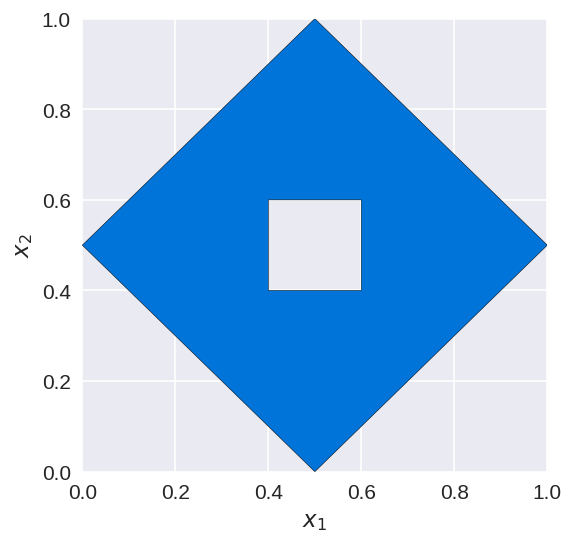

In [22]:
fig = plt.figure(figsize=(5, 5), dpi=120)
square = Polygon([(0.4, 0.4), (0.4, 0.6), (0.6, 0.6), (0.6, 0.4)])
polygon = Polygon([(0, 0.5), (0.5, 1), (1, 0.5), 
                   (0.5, 0), (0, 0.5)])
polygon = polygon.difference(square)

ax = fig.add_subplot(111)
ax.add_patch(PolygonPatch(polygon, fc=BLUE))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

In [23]:
def fun(x):
    x = np.array(x)
    if len(x.shape) == 1:
        point = Point(x[0], x[1])
        return 1 if polygon.contains(point) else 0
    else:
        return np.array([fun(xi) for xi in x])[np.newaxis].T

In [24]:
X = np.linspace(0, 1, 41)
P = np.array(list(itertools.product(X, repeat=2)))
T = fun(P)
N = len(T)
savemat('matlab/3.mat', mdict={'P': P, 'T': T})

## №4. Разбиение плоскости на $n$ классов

In [25]:
def get_position_for_text(polygon):
    coord = polygon.exterior.centroid.coords.xy
    return coord[0][0], coord[1][0]

polygons = {
    1: Polygon([(0, 0), (0, 1), (.4, .8)]),
    2: Polygon([(0, 1), (1, 1), (.8, .6)]),
    3: Polygon([(1, 1), (1, 0), (.6, .2)]),
    4: Polygon([(1, 0), (0, 0), (.2, .4)]),
    5: Polygon([(.2, .4), (.4, .8), (.5, .5)]),
    6: Polygon([(.4, .8), (.8, .6), (.5, .5)]),
    7: Polygon([(.6, .2), (.8, .6), (.5, .5)]),
    8: Polygon([(.2, .4), (.6, .2), (.5, .5)])
}

colors = {
    1: '#0074D9',
    2: '#39CCCC',
    3: '#2ECC40',
    4: '#F012BE',
    5: '#FF851B',
    6: '#FF4136',
    7: '#B10DC9',
    8: '#3D9970',
}

In [26]:
def fun(x):
    x = np.array(x)
    if len(x.shape) == 1:
        point = Point(x[0], x[1])
        for i, p in polygons.items():
            if point.distance(p) < 1e-8:
                return i
    else:
        return np.array([fun(xi) for xi in x])[np.newaxis].T

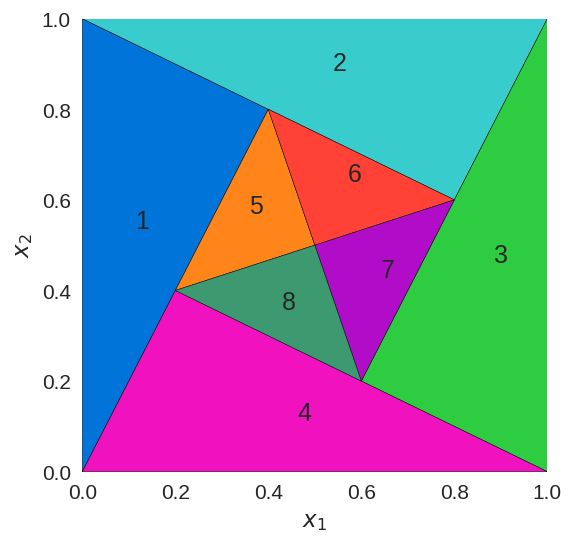

In [27]:
fig = plt.figure(figsize=(5, 5), dpi=120)
ax = fig.add_subplot(111)
for i, p in polygons.items():
    ax.add_patch(PolygonPatch(p, fc=colors[i]))
    ax.annotate(i, xy=get_position_for_text(p), size=15)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

In [28]:
X = np.linspace(0, 1, 41)
P = np.array(list(itertools.product(X, repeat=2)))
T = fun(P)
savemat('matlab/4.mat', mdict={'P': P, 'T': T})